# Experiment 4
Evaluate models using attention distributions instead of example sources.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import glob
from utils import *
from PIL import Image
import matplotlib.gridspec as gridspec
from models_new import *
#functions_list()

## Select Model and Data

In [2]:
paths=[
    '0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05'
]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nets = []
evaluations = []

for p in paths:
    model_name = path_to_model(p)
    nets.append(load_net(model_name, device))

PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/26.pt
/0709Exp1 9Exp 1


## Define Functions
Attention map Distribution function (and respective plot functions)

In [4]:
def attention_distribution(net,
                           out_ = None,
                           layer_no = 3,
                           repetitions = 1
                          ):
    assert out_ in ['subclass', 'confusion', None, 'FRI', 'FRII', 'gates', 'epochs'], f"{out_} not accepted for out_, must be in ['subclass', 'confusion', None, 'FRI', 'FRII']"
    
    fri, frii = [], []
    unc_fri, unc_frii = [], []
    out = []
    
    distr = []
    unc_distr = []
    true_distr = []
    false_distr = []
    
    if out_ in ['subclass', 'confusion']:
        maps = [
            np.zeros((150, 150)), np.zeros((150, 150)),
            np.zeros((150, 150)), np.zeros((150, 150))
        ]
        data_distributions = [
            np.zeros((150, 150)), np.zeros((150, 150)),
            np.zeros((150, 150)), np.zeros((150, 150))
        ]
        count = [0, 0, 0, 0]
    else:
        maps = [
            np.zeros((150, 150)), 
            np.zeros((150, 150))
        ]
        originals = [
            [np.zeros((150, 150)), np.zeros((150, 150))],
            [np.zeros((75, 75)), np.zeros((75, 75))],
            [np.zeros((37, 37)), np.zeros((37, 37))]
        ]
    
    counter = 0
    for r in range(repetitions):
        data, out_date = data_call('MiraBest', dataloader=True)
        # Create set of sorted batch for each repetition
        for d in data:
            batch = d[0]
            labels= d[1]
            
            for idx, j in enumerate(labels):
                if j <=2:
                    fri.append(batch[idx])
                elif j<=4:
                    unc_fri.append(batch[idx])
                elif j<=6:
                    frii.append(batch[idx])
                elif j<=7:
                    unc_frii.append(batch[idx])
                else:
                    pass
    # Group according to out_
    if out_ == 'subclass':
        raw_data = [fri, unc_fri, 
                frii, unc_frii]
        labels = [0, 0, 
                  1, 1]
    else:
        raw_data = [fri + unc_fri, 
                frii + unc_frii]
        labels = [0, 1]
        
    false = []
    for idx, batch in enumerate(raw_data):
        batch = torch.stack(batch).view(-1,1,150,150)
        # Generate attention maps
        amap, original = attentions_func(batch, net, mean=True, device=device, layer_name_base='attention', layer_no=layer_no)
        if out_ == 'confusion':
            pred = net.forward(batch.cuda()).detach().cpu().numpy().argmax(axis=1)

            maps[idx] += np.asarray(amap)[np.where(pred==idx)].mean(axis=0)
            maps[idx+2] += np.asarray(amap)[np.where(pred!=idx)].mean(axis=0)

            data_distributions[idx] += np.asarray(batch)[np.where(pred==idx)].sum(axis=0).squeeze()
            data_distributions[idx+2] += np.asarray(batch)[np.where(pred!=idx)].sum(axis=0).squeeze()
            false.append(np.asarray(batch)[np.where(pred!=idx)].squeeze())
            count[idx] += np.asarray(batch)[np.where(pred==idx)].shape[0]
            count[idx+2] += np.asarray(batch)[np.where(pred!=idx)].shape[0]
        elif out_ in ['gates','epochs']:
            out.append(np.asarray(original[0::3]).squeeze().mean(axis=0))
            out.append(np.asarray(original[1::3]).squeeze().mean(axis=0))
            out.append(np.asarray(original[2::3]).squeeze().mean(axis=0))
            out.append(np.asarray(amap).mean(axis=0))
        else:
            maps[idx] += np.asarray(amap).mean(axis=0)
    
    maps = np.asarray(maps)/repetitions
    if out_ == 'subclass':
        data_distributions = np.asarray([
            np.stack(fri).mean(axis=(0,1)),
            np.stack(unc_fri).mean(axis=(0,1)),
            np.stack(frii).mean(axis=(0,1)),
            np.stack(unc_frii).mean(axis=(0,1))
        ])/2+0.5
        return maps, data_distributions
    
    elif out_ == 'confusion':
        for i in range(4):
            data_distributions[i] = data_distributions[i]/count[i]/2+0.5
        return maps, np.asarray(data_distributions), false
    elif out_=='gates':
        data_distributions = np.asarray([np.stack(fri+unc_fri).mean(axis=(0,1)), np.stack(frii+unc_frii).mean(axis=(0,1))])/2+0.5
        return out, data_distributions
    elif out_=='epochs':
        data_distributions = np.asarray([np.stack(fri+unc_fri).mean(axis=(0,1)), np.stack(frii+unc_frii).mean(axis=(0,1))])/2+0.5
        return out, data_distributions
    elif out_ == 'FRI':
        data_distributions = np.asarray([np.stack(fri+unc_fri).mean(axis=(0,1)), 
                                         np.stack(frii+unc_frii).mean(axis=(0,1))
                                        ])/2+0.5
        return maps[0], data_distributions[0]
    elif out_ == 'FRII':
        data_distributions = np.asarray([np.stack(fri+unc_fri).mean(axis=(0,1)), 
                                         np.stack(frii+unc_frii).mean(axis=(0,1))
                                        ])/2+0.5
        return maps[1], data_distributions[1]
    else:
        data_distributions = np.asarray([np.stack(fri+unc_fri).mean(axis=(0,1)), np.stack(frii+unc_frii).mean(axis=(0,1))])/2+0.5
        return maps, data_distributions

In [5]:
def plot_distributions(amaps, data_distr, method=None, cmap='magma', cmap2='cool'):
    plt.rcParams.update({'font.size': 14})
    if method=='subclass':
        plt.figure(figsize=(10,20))
        
        plt.subplot(421)
        plt.imshow(data_distr[0], cmap=cmap)
        plt.title(f'FRI')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[0], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)

        plt.subplot(422)
        plt.imshow(amaps[0], cmap=cmap)
        plt.title(f'Att. Map FRI')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        
        plt.subplot(423)
        plt.imshow(data_distr[1], cmap=cmap)
        plt.title(f'FRI Unc.')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[1], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)

        plt.subplot(424)
        plt.imshow(amaps[1], cmap=cmap)
        plt.title(f'Att. Map FRI Unc.')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()

        plt.subplot(425)
        plt.imshow(data_distr[2], cmap=cmap)
        plt.title(f'FRII')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[2], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)
        
        plt.subplot(426)
        plt.imshow(amaps[2], cmap=cmap)
        plt.title(f'Att. Map FRII')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        
        plt.subplot(427)
        plt.imshow(data_distr[3], cmap=cmap)
        plt.title(f'FRII Unc.')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[3], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)

        plt.subplot(428)
        plt.imshow(amaps[3], cmap=cmap)
        plt.title(f'Att. Map FRII Unc.')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()

        plt.show()

    elif method=='confusion':
        
        # Binary Confusion Matrix
        def plot_conf_mat2(conf_matrix, normalised=True, n_classes=2, format_input=None, title='Confusion Matrix', size = (8,8)):
            # Following along the lines of (from the github on 29.04.2020)
            # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
            classes = ['FRI','FRII']
            xticks_rotation='horizontal'
            matrix = conf_matrix.copy() #Otherwise can change matrix inplace, which is undesirable for potential further processing.
            temp = np.asarray(matrix)
            
            values_format = '.4g'
            if normalised==True:
                values_format = '.1%'
                for i in range(matrix.shape[0]):
                    matrix = matrix.astype('float64') 
                    matrix[i] = matrix[i]/matrix[i].sum()
            if type(format_input) == str:
                values_format = format_input            
            # Initialise figure
            fig, ax = plt.subplots(figsize=size)
            img = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.magma)
            fig.colorbar(img, ax=ax)
            cmap_min, cmap_max = img.cmap(0), img.cmap(256)

            # print text with appropriate color depending on background
            text = np.empty_like(matrix, dtype=object)
            thresh = (matrix.max() + matrix.min()) / 2.0
            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if matrix[i, j] < thresh else cmap_min
            ax.set(xticks=[75, 225],
                   yticks=[75, 225],
                   xticklabels=classes,
                   yticklabels=classes,
                   ylabel="True label",
                   xlabel="Predicted label")
            ax.set_ylim((299, -1))
            plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
            if title:
                plt.title(title)
            plt.show()
        
        img = np.zeros((300,300))
        img[:150,:150]+=amaps[0]
        img[150:,:150]+=amaps[3]
        img[:150,150:]+=amaps[2]
        img[150:,150:]+=amaps[1]
        plot_conf_mat2(img, normalised=False, title=None, size=(10,8))
    
    elif method == 'gates':
        plt.figure(figsize = (10,15))
        
        plt.subplot(421)
        plt.imshow(amaps[3], cmap=cmap)
        plt.title(f'Average Att. Map')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(422)
        plt.imshow(amaps[7], cmap=cmap)
        plt.title(f'Average Att. Map')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(423)
        plt.imshow(amaps[0], cmap=cmap)
        plt.title(f'Attention Map 1')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(424)
        plt.imshow(amaps[4], cmap=cmap)
        plt.title(f'Attention Map 1')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(425)
        plt.imshow(amaps[1], cmap=cmap)
        plt.title(f'Attention Map 2')
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        
        plt.subplot(426)
        plt.imshow(amaps[5], cmap=cmap)
        plt.title(f'Attention Map 2')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(427)
        plt.imshow(amaps[2], cmap=cmap)
        plt.title(f'Attention Map 3')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(428)
        plt.imshow(amaps[6], cmap=cmap)
        plt.title(f'Attention Map 3')
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        
        plt.show()

    elif method in ['FRI', 'FRII']:
        plt.figure(figsize = (10, 5))

        plt.subplot(121)
        plt.imshow(amaps[0], cmap=cmap)
        plt.title(f'AMAP {method}')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()

        plt.subplot(123)
        plt.imshow(data_distr[0], cmap=cmap)
        plt.title(f'{method}')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()

        plt.show()

    else:
        plt.figure(figsize = (13, 5))

        plt.subplot(121)
        plt.imshow(data_distr[0], cmap=cmap)
        plt.title(f'FRI Sources')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[0], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)

        plt.subplot(122)
        plt.imshow(data_distr[1], cmap=cmap)
        plt.title(f'FRII Sources')
        plt.xticks([]); plt.yticks([])
        plt.colorbar()
        plt.contour(data_distr[1], np.linspace(0.001,0.1,4), alpha=0.7, cmap=cmap2)

        plt.show()

# Source Distributions By Class

In [6]:
method = None
amaps = None
repetitions = 100
for reps in range(repetitions):
    try:
        amaps_temp, data_distr_temp = attention_distribution(nets[0], out_=method)
        amaps += amaps_temp
        data_distr += data_distr_temp
    except:
        amaps, data_distr = attention_distribution(nets[0], out_=method)
amaps = amaps/repetitions
data_distr = data_distr/repetitions

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


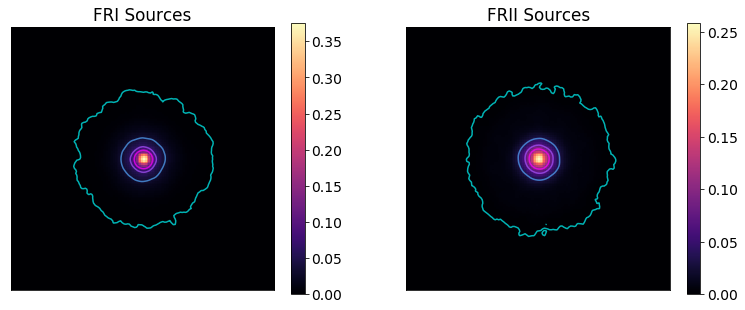

In [7]:
plot_distributions(amaps, data_distr, method,cmap='magma', cmap2='cool')


# Distributions by Attention Gates and True Labels

In [9]:
method = 'gates'
amaps = None
repetitions = 100
for reps in range(repetitions):
    try:
        amaps_temp, data_distr_temp = attention_distribution(nets[0], out_=method)
        for idx in range(len(amaps)):
            amaps[idx] += amaps_temp[idx]
        data_distr += data_distr_temp
    except:
        amaps, data_distr = attention_distribution(nets[0], out_=method)
for idx, amap in enumerate(amaps):
    amaps[idx] = amap/repetitions
data_distr = data_distr/repetitions

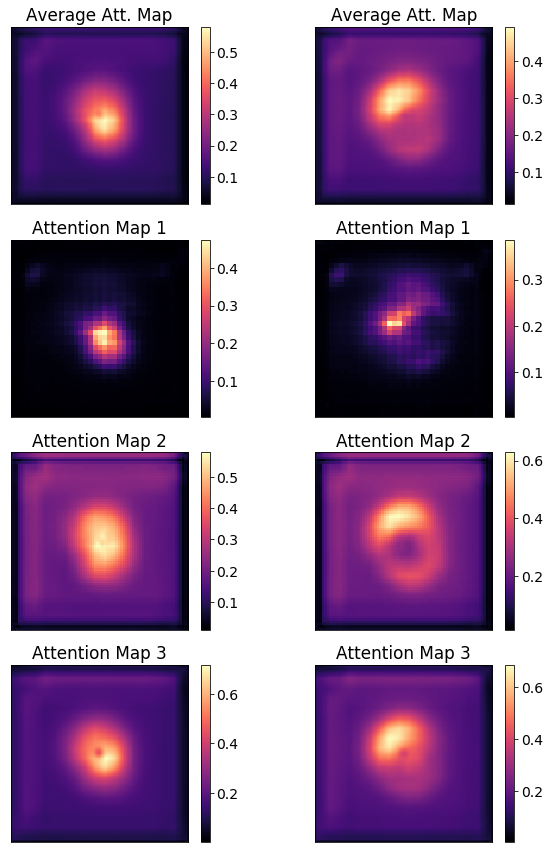

In [10]:
plot_distributions(amaps, data_distr, method)

# Distributions By Sub-Class (Confidence)
[4x2] plot with classes along the x-axis, and averaged over sources / attention maps.

In [11]:
method = 'subclass'
amaps = None
repetitions = 100
for reps in range(repetitions):
    try:
        amaps_temp, data_distr_temp = attention_distribution(nets[0], out_=method)
        amaps += amaps_temp
        data_distr += data_distr_temp
    except:
        amaps, data_distr = attention_distribution(nets[0], out_=method)
amaps = amaps/repetitions
data_distr = data_distr/repetitions

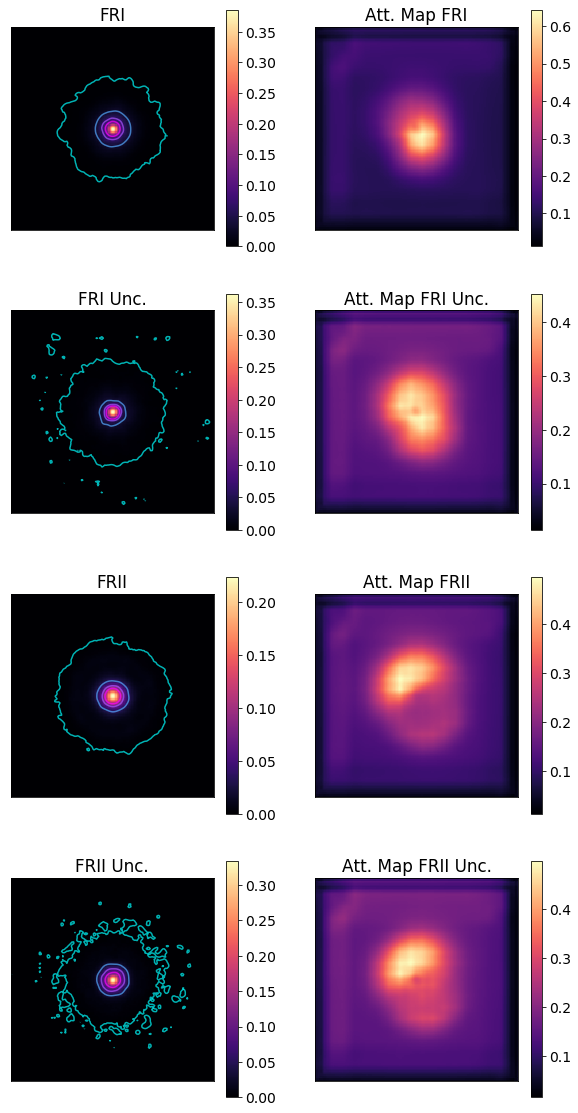

In [12]:
plot_distributions(amaps, data_distr, method, cmap='magma', cmap2='cool')


# Distributions in Confusion Matrix Format
i.e. [2x2]-grid with X is predicted, y is true label.

In [14]:
method = 'confusion'
amaps = None
repetitions = 100
for reps in range(repetitions):
    try:
        amaps_temp, data_distr_temp, false = attention_distribution(nets[0], out_=method)
        amaps += amaps_temp
        data_distr += data_distr_temp
    except:
        amaps, data_distr, false = attention_distribution(nets[0], out_=method)
amaps = amaps/repetitions
data_distr = data_distr/repetitions

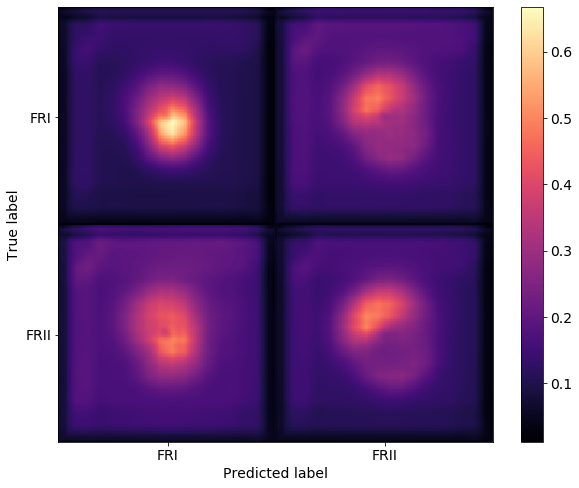

In [15]:
plot_distributions(amaps, data_distr, method)

# Distributions by Epoch
Seperate plots for FRI Classes throughout training (X-Axis is epoch)
 - Avg (FRI)
 - Gate1 (FRI)
 - Gate2 (FRI)
 - Gate3 (FRI)
 
Seperate plots for FRII Classes throughout training (X-Axis is epoch) 
 - Avg (FRII)
 - Gate1 (FRII)
 - Gate2 (FRII)
 - Gate3 (FRII)

In [16]:
method = 'epochs'
p = paths[0]
print(p)

# Create list all available models
available_epochs = []
for epoch_temp in range(1500):
    PATH = f'TrainedNetworks/{p}/{epoch_temp}.pt'
    if os.path.exists(PATH):
        available_epochs.append(PATH)

# Find properly spaced models
models = []
number = 5
epochs_of_interest = np.linspace(1,len(available_epochs), num=number ,endpoint=True,dtype=int)
for i in epochs_of_interest:
    models.append(available_epochs[i-1])

# Load each network into a temporary list
nets_temp = []
for name in models:
    nets_temp.append(load_net(name, device))

# Extract attention maps for the distributions (at large enough no of repetitions it doesnt matter that they are techincally different distributions)
maps = []
repetitions = 100
for n in nets_temp:
    amaps=None
    for reps in range(repetitions):
        try:
            amaps_temp, data_distr_temp = attention_distribution(n, out_=method)
            for idx in range(len(amaps)):
                amaps[idx] += amaps_temp[idx]
            data_distr += data_distr_temp
        except:
            amaps, data_distr = attention_distribution(n, out_=method)
    maps += amaps

0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05
PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/0.pt
/0709Exp1 9Exp 1
PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/3.pt
/0709Exp1 9Exp 1
PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/8.pt
/0709Exp1 9Exp 1
PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/13.pt
/0709Exp1 9Exp 1
PATH: TrainedNetworks/0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/26.pt
/0709Exp1 9Exp 1


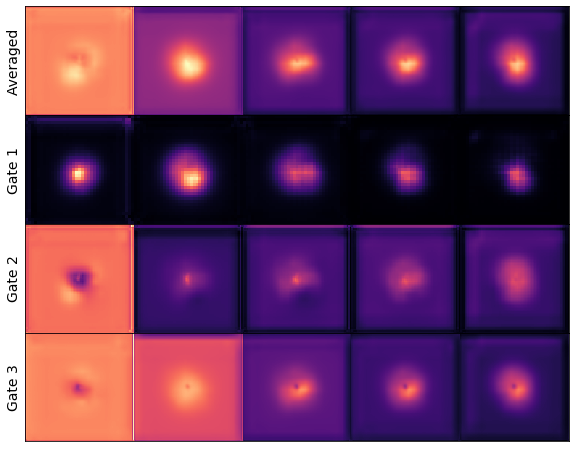

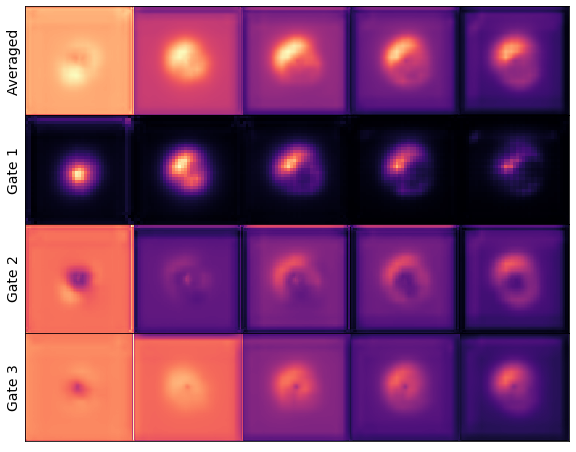

In [17]:
# Merging data into individual arrays:
data_distr = data_distr/repetitions

FRI_im1 = np.zeros((37, len(nets_temp)*37))
FRI_im2 = np.zeros((75, len(nets_temp)*75))
FRI_im3 = np.zeros((150, len(nets_temp)*150))
FRI_im4 = np.zeros((150, len(nets_temp)*150))

FRII_im1 = np.zeros((37, len(nets_temp)*37))
FRII_im2 = np.zeros((75, len(nets_temp)*75))
FRII_im3 = np.zeros((150, len(nets_temp)*150))
FRII_im4 = np.zeros((150, len(nets_temp)*150))
for i in range(len(nets_temp)):
    FRI_im1[0:37, 37*i:37*(i+1)] += maps[i*8+0]/repetitions
    FRI_im2[0:75, 75*i:75*(i+1)] += maps[i*8+1]/repetitions
    FRI_im3[0:150, 150*i:150*(i+1)] += maps[i*8+2]/repetitions
    FRI_im4[0:150, 150*i:150*(i+1)] += maps[i*8+3]/repetitions
    
    FRII_im1[0:37, 37*i:37*(i+1)] += maps[i*8+4]/repetitions
    FRII_im2[0:75, 75*i:75*(i+1)] += maps[i*8+5]/repetitions
    FRII_im3[0:150, 150*i:150*(i+1)] += maps[i*8+6]/repetitions
    FRII_im4[0:150, 150*i:150*(i+1)] += maps[i*8+7]/repetitions


# Plots:
plt.rcParams.update({'font.size': 14})
cmap='magma'
scaling=2

plt.figure(figsize=(5*scaling, 4*scaling))
gs1 = gridspec.GridSpec(4,1)
gs1.update(wspace=0, hspace=0)

plt.subplot(gs1[0])
plt.imshow(FRI_im4, cmap=cmap)
#plt.yticks([0, 36, 75, 150])
plt.ylabel('Averaged')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[1])
plt.imshow(FRI_im1, cmap=cmap)
#plt.yticks([0, 36])
plt.ylabel('Gate 1')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[2])
plt.imshow(FRI_im2, cmap=cmap)
#plt.yticks([0, 36, 75])
plt.ylabel('Gate 2')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[3])
plt.imshow(FRI_im3, cmap=cmap)
#plt.yticks([0, 36, 75, 150])
plt.ylabel('Gate 3')
plt.xticks([]); plt.yticks([])

plt.show()


plt.figure(figsize=(5*scaling, 4*scaling))
gs1 = gridspec.GridSpec(4,1)
gs1.update(wspace=0, hspace=0)

plt.subplot(gs1[0])
plt.imshow(FRII_im4, cmap=cmap)
#plt.yticks([0, 36, 75, 150])
plt.ylabel('Averaged')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[1])
plt.imshow(FRII_im1, cmap=cmap)
#plt.yticks([0, 36])
plt.ylabel('Gate 1')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[2])
plt.imshow(FRII_im2, cmap=cmap)
#plt.yticks([0, 36, 75])
plt.ylabel('Gate 2')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[3])
plt.imshow(FRII_im3, cmap=cmap)
#plt.yticks([0, 36, 75, 150])
plt.ylabel('Gate 3')
plt.xticks([]); plt.yticks([])

plt.show()

## Publication Epoch Distribution Plot

0.3724398 0.6414579565227067


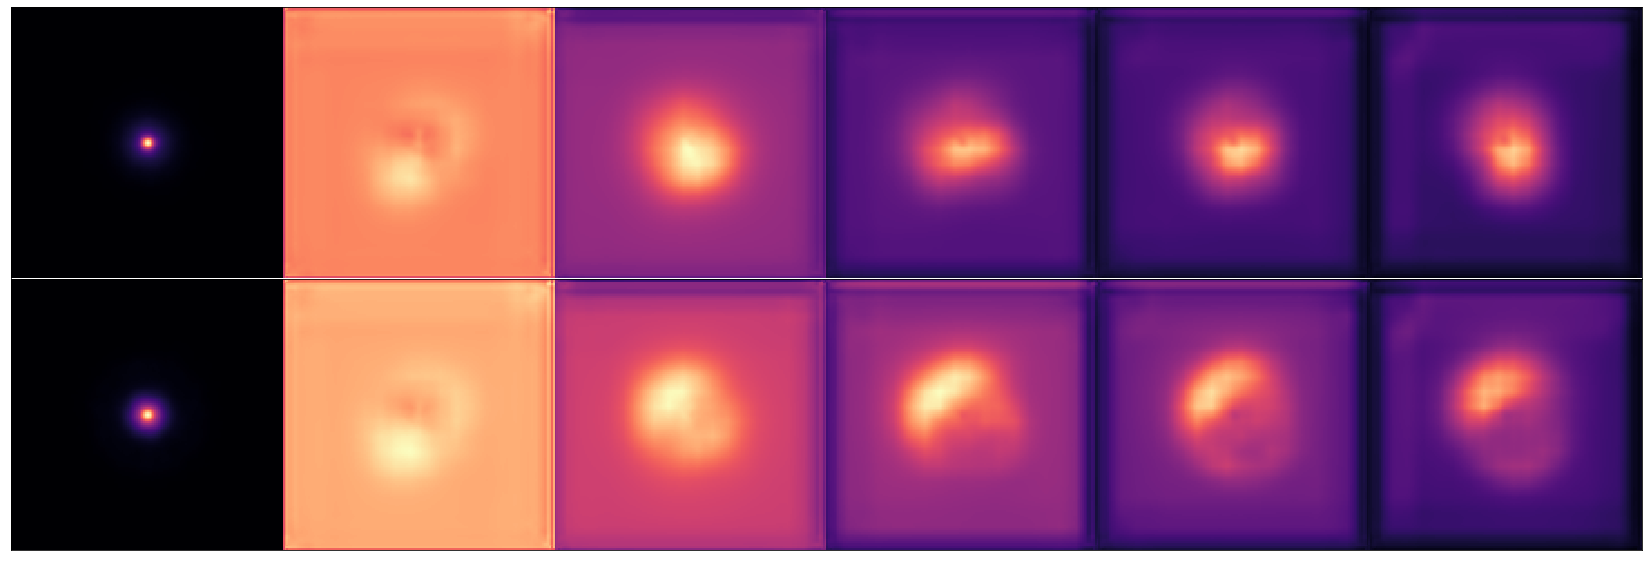

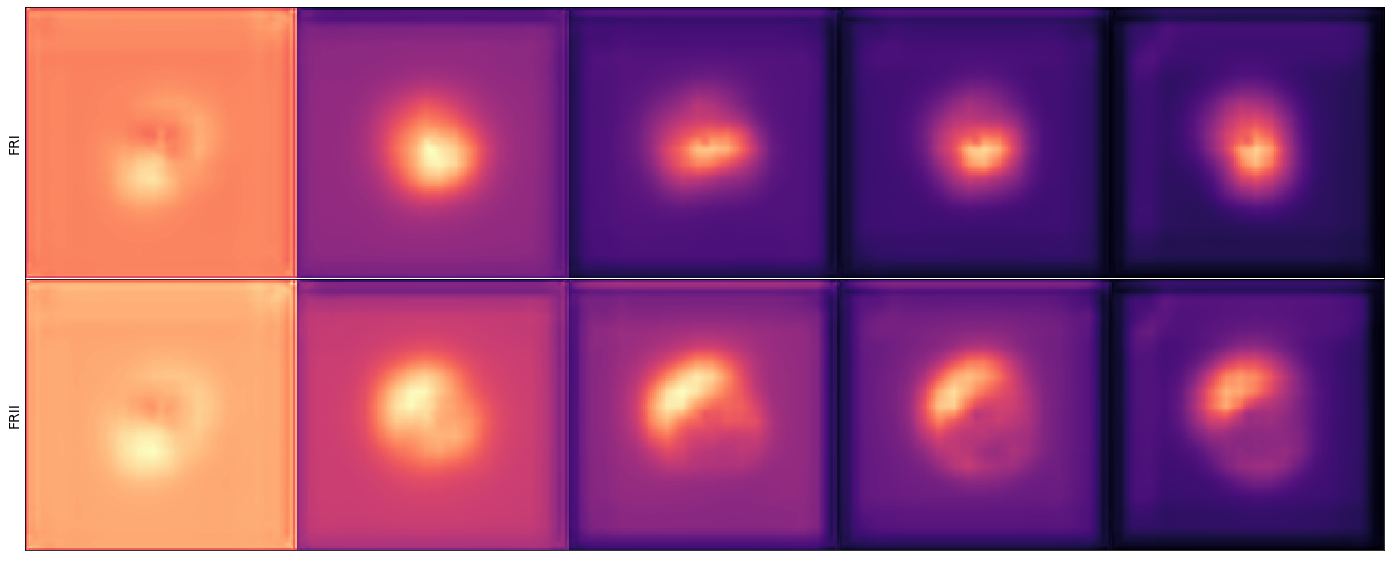

In [18]:
# Publication Plots
plt.rcParams.update({'font.size': 14})
cmap='magma'
scaling=2

FRI_epoch = np.zeros([150, 150*6])
FRII_epoch= np.zeros([150, 150*6])

FRI_epoch[:,:150] = data_distr[0]/data_distr[0].max()
FRI_epoch[:,150:] = FRI_im4/FRI_im4.max()
FRII_epoch[:,:150] = data_distr[1]/data_distr[1].max()
FRII_epoch[:,150:] = FRII_im4/FRII_im4.max()


scaling=5
plt.figure(figsize=(6*scaling, 2*scaling))
gs1 = gridspec.GridSpec(2,1)
gs1.update(wspace=0, hspace=0)

plt.subplot(gs1[0])
plt.imshow(FRI_epoch, cmap=cmap)
#plt.ylabel('FRI')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[1])
plt.imshow(FRII_epoch, cmap=cmap)
#plt.ylabel('FRII')
plt.xticks([]); plt.yticks([])

plt.show()


plt.figure(figsize=(5*scaling, 2*scaling))
gs1 = gridspec.GridSpec(2,1)
gs1.update(wspace=0, hspace=0)

plt.subplot(gs1[0])
plt.imshow(FRI_im4, cmap=cmap)
plt.ylabel('FRI')
plt.xticks([]); plt.yticks([])

plt.subplot(gs1[1])
plt.imshow(FRII_im4, cmap=cmap)
plt.ylabel('FRII')
plt.xticks([]); plt.yticks([])

plt.show()

# Distributions for Each Normalisation and Aggregation Model
One [4x4]-plot for FRI / FRII classes.

In [19]:
paths_agg_norm = [
    '0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05',
    '0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05',
    '0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05',
    '0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05',
       
    '0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05',
    '0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05',
    '0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05',
    '0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05',
    
    '0709Exp2-std_mean_norm-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05',
    '0709Exp2-std_mean_norm-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05',
    '0709Exp2-std_mean_norm-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05',
    '0709Exp2-std_mean_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05',
    
    #'0709Exp2-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-0.0001',
    '0709Exp2-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05',
    '0709Exp2-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05',
    '0709Exp2-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05',
    '0709Exp1-range_norm-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05'
]

# Extract list of respective networks
nets_agg_norm = []
for p in paths_agg_norm:
    model_name = path_to_model(p)
    nets_agg_norm.append(load_net(model_name, device))

# Extract attention maps for respective networks
method = None
maps = []
repetitions = 100
for n in nets_agg_norm:
    amaps=None
    for reps in range(repetitions):
        try:
            amaps_temp, data_distr_temp = attention_distribution(n, out_=method)
            for idx in range(len(amaps)):
                amaps[idx] += amaps_temp[idx]
            data_distr += data_distr_temp
        except:
            amaps, data_distr = attention_distribution(n, out_=method)
    maps += list(amaps)

PATH: TrainedNetworks/0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05/18.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05/51.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05/57.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-softmax-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/37.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05/98.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetconcat-5e-05/98.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetdeep_sup-5e-05/98.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-sigmoid-MiraBestNOHYBRIDAdam-AGRadGalNetft-5e-05/97.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-std_mean_norm-MiraBestNOHYBRIDAdam-AGRadGalNetmean-5e-05/93.pt
/0709Exp2 9Exp 2
PATH: TrainedNetworks/0709Exp2-std_mean_n

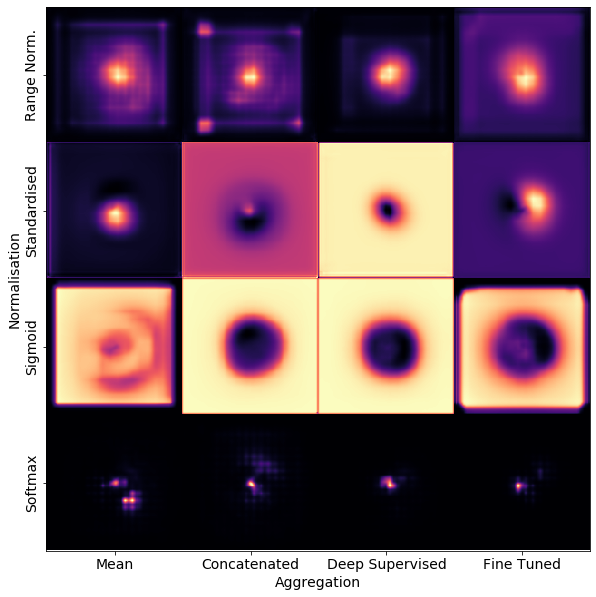

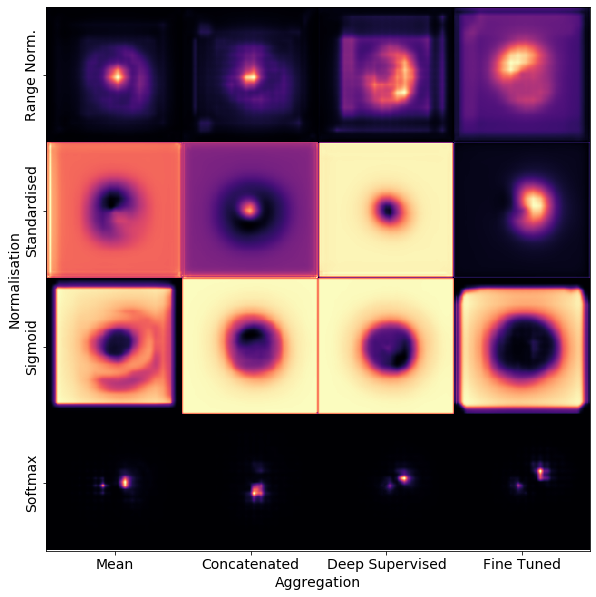

In [20]:
img1 = np.zeros((150*4, 150*4))
img2 = np.zeros((150*4, 150*4))

def range_norm(arr):
    arr = arr-arr.min()
    arr = arr/arr.max()
    return arr

for norm in range(4):
    for agg in range(4):
        fri = range_norm(maps[2*(agg*4+norm)])
        frii= range_norm(maps[2*(agg*4+norm)+1])
        
        img1[150*(3-agg):150*(3-agg+1), 150*(norm):150*(norm+1)] += fri
        img2[150*(3-agg):150*(3-agg+1), 150*(norm):150*(norm+1)] += frii

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10,10))
plt.imshow(img1, cmap='magma')
plt.xticks(np.linspace(75, 525, 4, endpoint=True), ['Mean','Concatenated','Deep Supervised', 'Fine Tuned'])
plt.yticks(np.linspace(525, 75, 4, endpoint=True), ['Softmax', 'Sigmoid', 'Standardised', 'Range Norm.'], rotation='vertical', va='center')
plt.ylim(600,0)
plt.xlabel('Aggregation'); plt.ylabel('Normalisation')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(img2, cmap='magma')
plt.xticks(np.linspace(75, 525, 4, endpoint=True), ['Mean','Concatenated','Deep Supervised', 'Fine Tuned'])
plt.yticks(np.linspace(525, 75, 4, endpoint=True), ['Softmax', 'Sigmoid', 'Standardised', 'Range Norm.'], rotation='vertical', va='center')
plt.ylim(600,0)
plt.xlabel('Aggregation'); plt.ylabel('Normalisation')
plt.show()